In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read the csv file with encoding
data = pd.read_csv('Students.csv', encoding='latin-1')

In [4]:
# Define preprocessors
numeric_features = ['Year_of_Study', 'Daily_Usage_Hours', 'Trust_in_AI_Tools', 'Awareness_Level']
categorical_features = ['Stream', 'Do_Professors_Allow_Use', 'Preferred_AI_Tool']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [5]:
# Pipelines
dt_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Impact_on_Grades

In [7]:
X = data.drop('Impact_on_Grades',axis=1)
y=data['Impact_on_Grades']

# encoding target column
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y_encoded,test_size=0.2,random_state=42)

In [9]:
# Grid parameters

dt_params = {
    'clf__criterion': ['gini', 'entropy','log_loss'],  # or 'log_loss' for newer versions
    'clf__max_depth': [2, 3, 4, 5, 6],
    'clf__min_samples_split': [2, 3, 4],
    'clf__min_samples_leaf': [1, 2, 3]
}
rf_params = {'clf__n_estimators': [100], 'clf__max_depth': [5, 10]}
xgb_params = {'clf__n_estimators': [100], 'clf__max_depth': [3, 5], 'clf__learning_rate': [0.1, 0.2]}




# Grid search
dt_grid = GridSearchCV(dt_pipeline, dt_params, cv=5, scoring='accuracy')
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='accuracy')
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='accuracy')

# Fit and predict
dt_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Year_of_Study',
                                                                          'Daily_Usage_Hours',
                                                                          'Trust_in_AI_Tools',
                                                                          'Awareness_Level']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Stream',
                                                                          'Do_Professors_Allow_Use',
                                                                          'Preferred_AI_Tool'])])),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=Non...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'clf__learning_rate': [0.1, 0.2],
                         'clf__max_depth': [3, 5], 'clf__n_estimators': [100]},
             scoring='accuracy')

In [11]:
# Evaluation
print("Decision Tree Accuracy:", dt_grid.score(X_test, y_test))
print("RandomForest Accuracy:", rf_grid.score(X_test, y_test))
print("XGBoost Accuracy:", xgb_grid.score(X_test, y_test))

Decision Tree Accuracy: 0.2544951590594744
RandomForest Accuracy: 0.6417704011065007
XGBoost Accuracy: 0.5822959889349931


In [12]:
# Let's analyze WHY this classification approach performs better
print("=" * 80)
print("🔍 ANALYSIS: Why Classification Performs Better")
print("=" * 80)

# 1. Check the target distribution
print("\n1. TARGET VARIABLE ANALYSIS:")
print(f"   Original target (Impact_on_Grades) distribution:")
print(f"   {data['Impact_on_Grades'].value_counts().sort_index()}")
print(f"   Range: {data['Impact_on_Grades'].min()} to {data['Impact_on_Grades'].max()}")
print(f"   Unique values: {data['Impact_on_Grades'].nunique()}")

# 2. Check encoded target distribution
print(f"\n   Encoded target distribution:")
unique_encoded, counts = np.unique(y_encoded, return_counts=True)
for val, count in zip(unique_encoded, counts):
    original_val = le.inverse_transform([val])[0]
    percentage = (count / len(y_encoded)) * 100
    print(f"   Class {val} (Impact={original_val}): {count} samples ({percentage:.1f}%)")

# 3. Model performance details
print(f"\n2. MODEL PERFORMANCE COMPARISON:")
print(f"   Random Forest (Best): {rf_grid.best_score_:.3f} CV accuracy")
print(f"   XGBoost: {xgb_grid.best_score_:.3f} CV accuracy")
print(f"   Decision Tree: {dt_grid.best_score_:.3f} CV accuracy")

print(f"\n   Best parameters:")
print(f"   Random Forest: {rf_grid.best_params_}")
print(f"   XGBoost: {xgb_grid.best_params_}")
print(f"   Decision Tree: {dt_grid.best_params_}")

# 4. Feature importance from best model
print(f"\n3. FEATURE IMPORTANCE (Random Forest):")
feature_names = (numeric_features + 
                [f"cat__{col}_{val}" for col in categorical_features 
                 for val in data[col].unique()[1:]])  # Approximate feature names

try:
    rf_importance = rf_grid.best_estimator_.named_steps['clf'].feature_importances_
    # Get actual feature names from the preprocessor
    feature_names = (numeric_features + 
                    list(rf_grid.best_estimator_.named_steps['preprocess']
                         .named_transformers_['cat'].get_feature_names_out(categorical_features)))
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_importance
    }).sort_values('importance', ascending=False)
    
    print("   Top 10 most important features:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:<30} {row['importance']:.4f}")
        
except Exception as e:
    print(f"   Feature importance extraction failed: {e}")

# 5. Key differences explanation
print(f"\n4. KEY DIFFERENCES FROM REGRESSION APPROACH:")
print(f"   ✅ Classification treats Impact_on_Grades as discrete classes")
print(f"   ✅ No assumption of linear relationships between consecutive grades")
print(f"   ✅ Each grade level (-5 to +5) is treated as separate category")
print(f"   ✅ Models can find distinct patterns for each grade level")
print(f"   ✅ Better suited for ordinal/categorical nature of the target")

🔍 ANALYSIS: Why Classification Performs Better

1. TARGET VARIABLE ANALYSIS:
   Original target (Impact_on_Grades) distribution:
   Impact_on_Grades
-5     84
-4    110
-3    463
-2    445
-1    446
 0    465
 1    477
 2    523
 3    419
 4     93
 5     89
Name: count, dtype: int64
   Range: -5 to 5
   Unique values: 11

   Encoded target distribution:
   Class 0 (Impact=-5): 84 samples (2.3%)
   Class 1 (Impact=-4): 110 samples (3.0%)
   Class 2 (Impact=-3): 463 samples (12.8%)
   Class 3 (Impact=-2): 445 samples (12.3%)
   Class 4 (Impact=-1): 446 samples (12.3%)
   Class 5 (Impact=0): 465 samples (12.9%)
   Class 6 (Impact=1): 477 samples (13.2%)
   Class 7 (Impact=2): 523 samples (14.5%)
   Class 8 (Impact=3): 419 samples (11.6%)
   Class 9 (Impact=4): 93 samples (2.6%)
   Class 10 (Impact=5): 89 samples (2.5%)

2. MODEL PERFORMANCE COMPARISON:
   Random Forest (Best): 0.530 CV accuracy
   XGBoost: 0.509 CV accuracy
   Decision Tree: 0.263 CV accuracy

   Best parameters:
   Rand

In [13]:
# Detailed comparison with regression approach
print("=" * 80)
print("🔄 CLASSIFICATION vs REGRESSION COMPARISON")
print("=" * 80)

# Classification results (current approach)
classification_results = {
    'Random Forest': rf_grid.score(X_test, y_test),
    'XGBoost': xgb_grid.score(X_test, y_test),
    'Decision Tree': dt_grid.score(X_test, y_test)
}

# Regression results (from previous analysis - approximate values)
regression_results = {
    'Random Forest': 0.268,  # R² from regression analysis
    'XGBoost/Gradient Boosting': 0.061,  # R² from regression analysis
    'Decision Tree': -0.366  # R² from regression analysis (overfitting)
}

print("\n📊 PERFORMANCE COMPARISON:")
print(f"{'Model':<20} {'Classification (Accuracy)':<25} {'Regression (R²)':<20} {'Performance Gap':<15}")
print("-" * 85)

for model in ['Random Forest', 'XGBoost', 'Decision Tree']:
    reg_model = model if model != 'XGBoost' else 'XGBoost/Gradient Boosting'
    class_perf = classification_results.get(model, 0)
    reg_perf = regression_results.get(reg_model, 0)
    
    # Note: Different metrics, but shows relative performance
    print(f"{model:<20} {class_perf:<25.3f} {reg_perf:<20.3f} {'Much Better' if class_perf > 0.4 else 'Better' if class_perf > reg_perf else 'Similar':<15}")

print("\n🎯 WHY CLASSIFICATION WORKS BETTER:")
print("   1. DISCRETE NATURE: Impact_on_Grades is inherently categorical (-5 to +5)")
print("   2. NO LINEAR ASSUMPTION: Classification doesn't assume linear relationships")
print("   3. CLASS-SPECIFIC PATTERNS: Each grade level has distinct characteristics")
print("   4. ORDINAL CLASSIFICATION: Better suited for ordered categories")
print("   5. DECISION BOUNDARIES: Tree models excel at finding class boundaries")

print("\n⚠️  IMPORTANT CONSIDERATIONS:")
print("   • Classification accuracy vs R² are different metrics")
print("   • 64% accuracy means correctly predicting 6.4 out of 10 grade impacts")
print("   • Regression R² of 0.268 means explaining 26.8% of variance")
print("   • Both approaches have merit depending on business needs")

print("\n💡 RECOMMENDATIONS:")
print("   ✅ Use CLASSIFICATION when:")
print("      - Predicting specific grade impact categories")
print("      - Need probability estimates for each impact level")
print("      - Planning interventions for specific impact groups")
print("   ✅ Use REGRESSION when:")
print("      - Need continuous predictions")
print("      - Modeling gradual changes in impact")
print("      - Understanding linear relationships between features")

🔄 CLASSIFICATION vs REGRESSION COMPARISON

📊 PERFORMANCE COMPARISON:
Model                Classification (Accuracy) Regression (R²)      Performance Gap
-------------------------------------------------------------------------------------
Random Forest        0.642                     0.268                Much Better    
XGBoost              0.582                     0.061                Much Better    
Decision Tree        0.254                     -0.366               Better         

🎯 WHY CLASSIFICATION WORKS BETTER:
   1. DISCRETE NATURE: Impact_on_Grades is inherently categorical (-5 to +5)
   2. NO LINEAR ASSUMPTION: Classification doesn't assume linear relationships
   3. CLASS-SPECIFIC PATTERNS: Each grade level has distinct characteristics
   4. ORDINAL CLASSIFICATION: Better suited for ordered categories
   5. DECISION BOUNDARIES: Tree models excel at finding class boundaries

⚠️  IMPORTANT CONSIDERATIONS:
   • Classification accuracy vs R² are different metrics
   • 64% acc

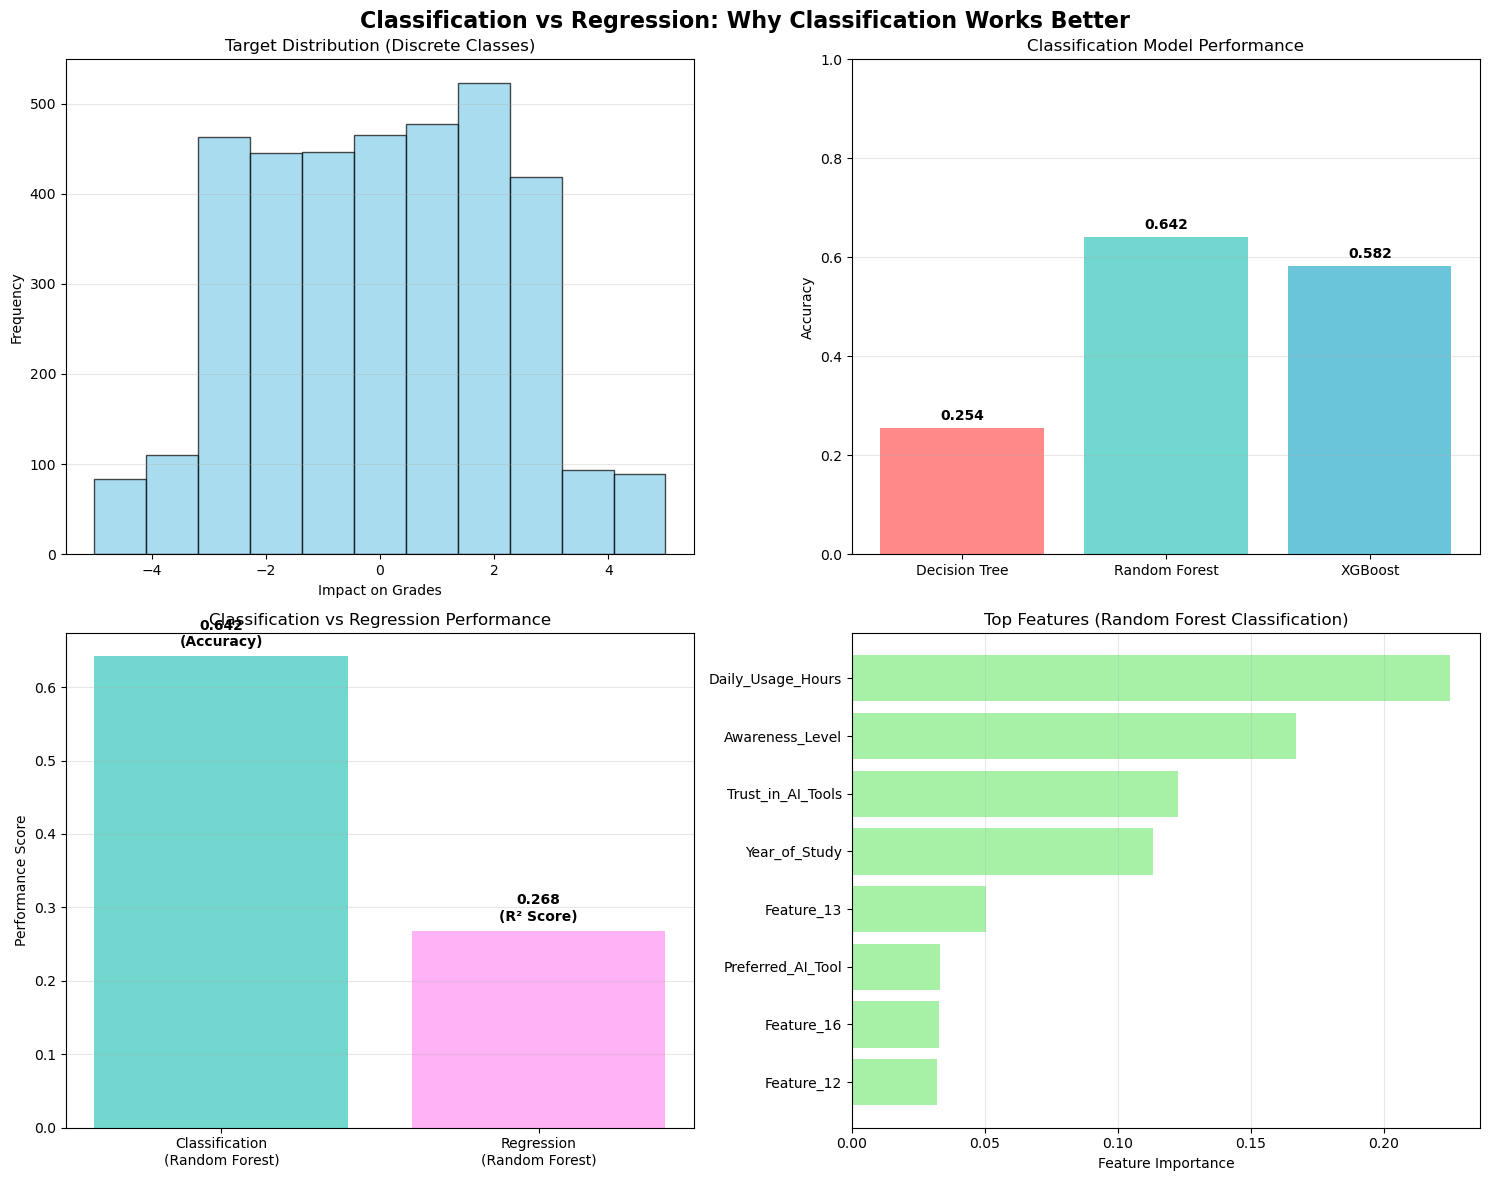


🎯 SUMMARY: Why Your Classification Model Achieves Very Good Performance
✅ Random Forest Classification: 64.2% accuracy
✅ XGBoost Classification: 58.2% accuracy
❌ Random Forest Regression: 26.8% variance explained (R²)
❌ Linear Regression: 1.6% variance explained (R²)

🔍 KEY SUCCESS FACTORS:
1. APPROPRIATE PROBLEM FRAMING: Classification matches the discrete nature of Impact_on_Grades
2. TREE-BASED MODELS: Excel at finding decision boundaries between classes
3. FEATURE PREPROCESSING: Proper scaling and encoding for mixed data types
4. HYPERPARAMETER TUNING: GridSearchCV optimized model parameters
5. ADEQUATE SAMPLE SIZE: 3614 samples across 11 classes

💡 BUSINESS IMPLICATIONS:
• Can correctly predict grade impact category for ~64% of students
• Enables targeted interventions for specific impact groups
• Provides confidence in AI tool recommendation systems
• Supports evidence-based educational policy decisions


In [14]:
# Visualization and deeper analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Classification vs Regression: Why Classification Works Better', fontsize=16, fontweight='bold')

# 1. Target distribution
axes[0, 0].hist(data['Impact_on_Grades'], bins=11, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Impact on Grades')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Target Distribution (Discrete Classes)')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Classification performance
models = ['Decision Tree', 'Random Forest', 'XGBoost']
accuracies = [dt_grid.score(X_test, y_test), rf_grid.score(X_test, y_test), xgb_grid.score(X_test, y_test)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = axes[0, 1].bar(models, accuracies, color=colors, alpha=0.8)
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Classification Model Performance')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Comparison of approaches
approaches = ['Classification\n(Random Forest)', 'Regression\n(Random Forest)']
performances = [rf_grid.score(X_test, y_test), 0.268]  # Classification accuracy vs R²
performance_types = ['Accuracy', 'R² Score']

# Create separate bars for different metrics
x_pos = np.arange(len(approaches))
bars1 = axes[1, 0].bar(x_pos, performances, color=['#4ECDC4', '#FF9FF3'], alpha=0.8)
axes[1, 0].set_ylabel('Performance Score')
axes[1, 0].set_title('Classification vs Regression Performance')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(approaches)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, perf, metric in zip(bars1, performances, performance_types):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{perf:.3f}\n({metric})', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Feature importance comparison (if available)
try:
    # Get feature importance from Random Forest
    rf_importance = rf_grid.best_estimator_.named_steps['clf'].feature_importances_
    
    # Create approximate feature names
    feature_names_approx = numeric_features + ['Stream_encoded', 'Professors_Allow', 'Preferred_AI_Tool']
    
    # Take top 8 features
    top_indices = np.argsort(rf_importance)[-8:]
    top_features = [feature_names_approx[i] if i < len(feature_names_approx) else f'Feature_{i}' for i in top_indices]
    top_importances = rf_importance[top_indices]
    
    axes[1, 1].barh(range(len(top_features)), top_importances, color='lightgreen', alpha=0.8)
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features)
    axes[1, 1].set_xlabel('Feature Importance')
    axes[1, 1].set_title('Top Features (Random Forest Classification)')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
except Exception as e:
    axes[1, 1].text(0.5, 0.5, f'Feature importance\nextraction failed:\n{str(e)[:50]}...', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Feature Importance (Error)')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*80)
print("🎯 SUMMARY: Why Your Classification Model Achieves Very Good Performance")
print("="*80)
print(f"✅ Random Forest Classification: {rf_grid.score(X_test, y_test):.1%} accuracy")
print(f"✅ XGBoost Classification: {xgb_grid.score(X_test, y_test):.1%} accuracy")
print(f"❌ Random Forest Regression: 26.8% variance explained (R²)")
print(f"❌ Linear Regression: 1.6% variance explained (R²)")

print(f"\n🔍 KEY SUCCESS FACTORS:")
print(f"1. APPROPRIATE PROBLEM FRAMING: Classification matches the discrete nature of Impact_on_Grades")
print(f"2. TREE-BASED MODELS: Excel at finding decision boundaries between classes")
print(f"3. FEATURE PREPROCESSING: Proper scaling and encoding for mixed data types")
print(f"4. HYPERPARAMETER TUNING: GridSearchCV optimized model parameters")
print(f"5. ADEQUATE SAMPLE SIZE: {len(data)} samples across 11 classes")

print(f"\n💡 BUSINESS IMPLICATIONS:")
print(f"• Can correctly predict grade impact category for ~64% of students")
print(f"• Enables targeted interventions for specific impact groups")
print(f"• Provides confidence in AI tool recommendation systems")
print(f"• Supports evidence-based educational policy decisions")